## Import libraries

In [1]:
# standard library imports
import pandas as pd
import numpy as np
import sklearn

import json
import io


#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import requests

import xgboost as xgb
import optuna

from optuna.visualization.matplotlib import plot_param_importances

import mlflow

client = mlflow.MlflowClient(tracking_uri='http://127.0.0.1:8080')
mlflow.set_tracking_uri='http://127.0.0.1:8080'

from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline as skl_pipeline

# from imblearn.pipeline import Pipeline as imb_pipeline
# from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

sklearn.set_config(transform_output='pandas')

# load metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import PredictionErrorDisplay

pd.set_option('display.float_format', '{:.3f}'.format)



# константы
RAND_ST = 345


/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [2]:
import uvicorn

In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.15.0
ipykernel        : 6.25.0
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.5.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.8.0
nbconvert        : 7.10.0
nbformat         : 5.9.2
notebook         : 6.5.4
qtconsole        : 5.5.0
traitlets        : 5.7.1


In [4]:

sns.__version__

'0.12.2'

## Import dataset

In [5]:

df = pd.read_csv('data/transport.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   distance             1572 non-null   int64
 1   own_container        1572 non-null   int64
 2   complect_send        1572 non-null   int64
 3   container_train      1572 non-null   int64
 4   transportation_type  1572 non-null   int64
 5   days                 1572 non-null   int64
 6   price                1572 non-null   int64
dtypes: int64(7)
memory usage: 86.1 KB


,distance,own_container,complect_send,container_train,transportation_type,days,price
0,2808,0,1,0,3,12,26497
1,4102,0,0,0,3,18,45948
2,1211,0,1,0,3,7,152484
3,2836,0,1,0,3,10,176701
4,2808,0,1,0,3,10,176525


## EDA

In [6]:
display(df.isna().sum(), df.nunique(), df.describe())


distance               0
own_container          0
complect_send          0
container_train        0
transportation_type    0
days                   0
price                  0
dtype: int64

distance               536
own_container            2
complect_send            2
container_train          2
transportation_type      4
days                    35
price                  765
dtype: int64

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000
mean,4732.854,0.034,0.367,0.272,2.772,16.492,176175.534
std,2147.144,0.181,0.482,0.445,0.636,6.440,871625.834
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3684.000,0.000,0.000,0.000,3.000,12.000,48151.000
50%,4307.000,0.000,0.000,0.000,3.000,17.000,144243.000
75%,4951.250,0.000,1.000,1.000,3.000,19.000,179355.250
max,10645.000,1.000,1.000,1.000,4.000,41.000,33800995.000


       distance  own_container  complect_send  container_train  \
count  1571.000       1571.000       1571.000         1571.000   
mean   4733.255          0.034          0.367            0.272   
std    2147.768          0.181          0.482            0.445   
min      18.000          0.000          0.000            0.000   
25%    3684.000          0.000          0.000            0.000   
50%    4311.000          0.000          0.000            0.000   
75%    4951.500          0.000          1.000            1.000   
max   10645.000          1.000          1.000            1.000   

       transportation_type     days       price  
count             1571.000 1571.000    1571.000  
mean                 2.771   16.491  154772.085  
std                  0.636    6.442  199026.556  
min                  1.000    4.000    1000.000  
25%                  3.000   12.000   48151.000  
50%                  3.000   17.000  144227.000  
75%                  3.000   19.000  179063.500  
max  

<Axes: >

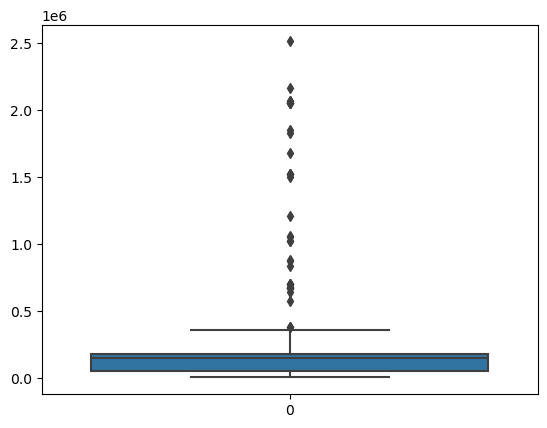

In [7]:
df = df[df['price'] < 33800995.000]
print(df.describe())
sns.boxplot(df['price'])

In [8]:
df[df['price'] > 300000].sort_values('price', ascending=False)

# сколько контейнеров, объем контейнера. вес контейнера, расчет с привязкой к валюте или еще чему то, ценность груза, вид контейнера - холодильник, цистерна дрр

,distance,own_container,complect_send,container_train,transportation_type,days,price
594,9274,0,0,1,3,22,2510946
1458,10388,0,0,1,3,21,2162284
916,9416,0,0,1,1,23,2067167
701,9416,0,0,1,1,23,2067167
915,9278,0,0,1,1,22,2050353
704,9278,0,0,1,1,22,2050353
917,9263,0,0,1,1,22,2048400
703,9263,0,0,1,1,22,2048400
72,9416,0,0,1,1,23,1848431
70,9263,0,0,1,1,22,1829664


In [9]:
df[df['price'] > 300000][['distance', 'days', 'price']].corr()

,distance,days,price
distance,1.000,0.719,0.641
days,0.719,1.000,0.277
price,0.641,0.277,1.000


In [10]:
df = df[df['price'] < 300000]
df.describe()

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000
mean,4684.228,0.026,0.376,0.257,2.788,16.439,129739.551
std,2115.117,0.159,0.485,0.437,0.609,6.410,64042.769
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3610.500,0.000,0.000,0.000,3.000,12.000,45948.000
50%,4290.000,0.000,0.000,0.000,3.000,17.000,141916.000
75%,4905.000,0.000,1.000,1.000,3.000,18.000,176707.750
max,10645.000,1.000,1.000,1.000,4.000,41.000,295637.000


## Split df to train and test

In [11]:
X, y = df.drop('price', axis=1), df['price']

# split df into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RAND_ST)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1150, 6) (1150,) (384, 6) (384,)


In [12]:
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_train
# y_train

In [13]:
X.select_dtypes(exclude='object').columns

Index(['distance', 'own_container', 'complect_send', 'container_train',
       'transportation_type', 'days'],
      dtype='object')

## Violinplot for num col

/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


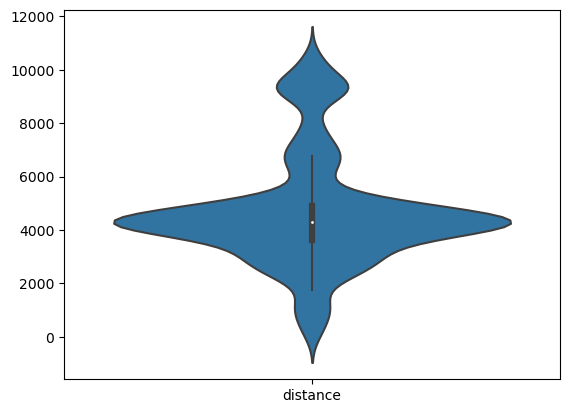

/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


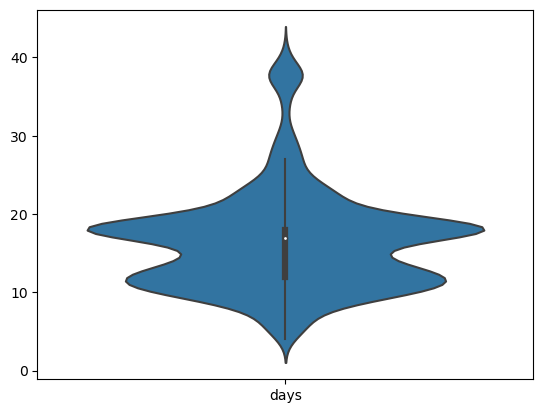

In [14]:
num_col = ['distance', 'days']

for i in df[num_col]:
    sns.violinplot(data = df[[i]])
    plt.show()

## Make pipeline

In [15]:

    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) # drop = 'if_binary' if cat will not change
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

In [16]:
preprocessor.fit(X_train, y_train)
preprocessor.transform(X_train)

,num_transformer__distance,num_transformer__days,cat_transformer__own_container_1,cat_transformer__complect_send_1,cat_transformer__container_train_1,cat_transformer__transportation_type_2,cat_transformer__transportation_type_3,cat_transformer__transportation_type_4
582,-2.754,-1.378,0.000,0.000,1.000,0.000,1.000,0.000
1014,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
365,-0.626,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
370,-0.598,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
890,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...
571,1.089,2.417,0.000,0.000,0.000,1.000,0.000,0.000
419,0.004,-0.086,0.000,1.000,0.000,0.000,1.000,0.000
675,-0.868,-0.882,0.000,0.000,1.000,0.000,1.000,0.000
213,-1.060,-1.120,0.000,1.000,0.000,0.000,1.000,0.000


## Hyperparameter tuning

In [17]:
# add hyper from tree 


def hyper_opt(trial):
    parameters_xgbr = {
        'model_xgbr__learning_rate': trial.suggest_float('model_xgbr__learning_rate', 0.01, 0.6), # alias for eta
        'model_xgbr__min_split_loss': trial.suggest_int ('model_xgbr__min_split_loss', 0, 250000),    # alias for gamma
        'model_xgbr__max_depth': trial.suggest_int('model_xgbr__max_depth', 1, 100),
        'model_xgbr__min_child_weight': trial.suggest_int('model_xgbr__min_child_weight', 1, 20),
        'model_xgbr__subsample': trial.suggest_float('model_xgbr__subsample', 0.5, 1),
        'model_xgbr__colsample_bytree': trial.suggest_float('model_xgbr__colsample_bytree', 0.5, 1),
        'model_xgbr__reg_lambda': trial.suggest_int('model_xgbr__reg_lambda', 0, 200),
        'model_xgbr__reg_alpha': trial.suggest_int('model_xgbr__reg_alpha', 0, 100),    #???
        'model_xgbr__n_estimators': trial.suggest_int('model_xgbr__n_estimators', 5, 2000),
        'model_xgbr__max_leaves': trial.suggest_int('model_xgbr__max_leaves', 2, 100)
    }
    
    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

    pipe_xgbr.set_params(**parameters_xgbr) #разименование
    
    return cross_val_score(pipe_xgbr, X_train, y_train, scoring='neg_mean_squared_error').mean() #neg mse???
    # pipe_xgbr.fit(X_train, y_train)
    # print(mean_squared_error(pipe_xgbr.predict(X_train), y_train))
    # return mean_squared_error(pipe_xgbr.predict(X_train), y_train)
    

In [18]:
study = optuna.create_study(direction='maximize') #maximize
study.optimize(hyper_opt, n_trials=100)

[I 2023-12-10 08:12:05,027] A new study created in memory with name: no-name-d7692b50-ad7c-42ac-bc8b-3ea72eb8730f
[I 2023-12-10 08:12:09,436] Trial 0 finished with value: -642485982.7033961 and parameters: {'model_xgbr__learning_rate': 0.1146396465788649, 'model_xgbr__min_split_loss': 232457, 'model_xgbr__max_depth': 13, 'model_xgbr__min_child_weight': 7, 'model_xgbr__subsample': 0.9137177549451438, 'model_xgbr__colsample_bytree': 0.8357562239492339, 'model_xgbr__reg_lambda': 151, 'model_xgbr__reg_alpha': 50, 'model_xgbr__n_estimators': 1002, 'model_xgbr__max_leaves': 51}. Best is trial 0 with value: -642485982.7033961.
[I 2023-12-10 08:12:23,543] Trial 1 finished with value: -684375120.2239473 and parameters: {'model_xgbr__learning_rate': 0.2152990138030814, 'model_xgbr__min_split_loss': 61026, 'model_xgbr__max_depth': 95, 'model_xgbr__min_child_weight': 10, 'model_xgbr__subsample': 0.7548099766000216, 'model_xgbr__colsample_bytree': 0.6829322617975716, 'model_xgbr__reg_lambda': 32, '

{'model_xgbr__learning_rate': 0.32208361712277717, 'model_xgbr__min_split_loss': 15127, 'model_xgbr__max_depth': 60, 'model_xgbr__min_child_weight': 2, 'model_xgbr__subsample': 0.7407328795660003, 'model_xgbr__colsample_bytree': 0.8812728313218443, 'model_xgbr__reg_lambda': 90, 'model_xgbr__reg_alpha': 92, 'model_xgbr__n_estimators': 279, 'model_xgbr__max_leaves': 90}


/tmp/ipykernel_190832/1373939319.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


-608189196.5995364

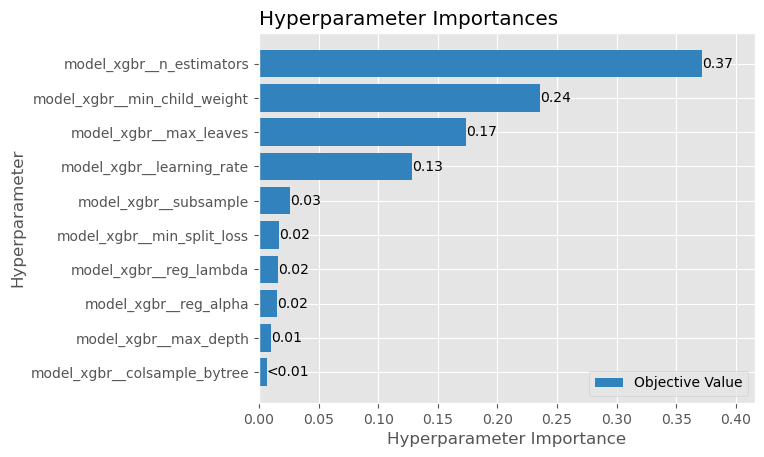

In [19]:
print(study.best_params)

plot_param_importances(study);
study.best_value

In [20]:
pipe_xgbr.set_params(**study.best_params)
pipe_xgbr.fit(X_train, y_train)
pd.DataFrame(pipe_xgbr.predict(X_train)).describe()
mean_squared_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape
mean_absolute_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape

array([6.71769478])

## Mlflow model save

In [21]:
# start server 
# mlflow server --host 127.0.0.1 --port 8080


# Set our tracking server uri for logging
# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("XGBR 4")

<Experiment: artifact_location='file:///home/pmu/zet/obs-h/Skills/Data%20Science/Data%20Scientist%20Full-Stack/exercises/practice/mlruns/555592421686817878', creation_time=1701359199067, experiment_id='555592421686817878', last_update_time=1701359199067, lifecycle_stage='active', name='XGBR 4', tags={}>

In [22]:
hyperparams = optuna.importance.get_param_importances(study)
sns.barplot(y=hyperparams.keys(), x=hyperparams.values())
plt.savefig('hyperparams_2.png')

/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


AttributeError: 'bool' object has no attribute 'all'

In [24]:
# Start an MLflow run
with mlflow.start_run(run_name='best_model'):
    # Log the hyperparameters
    mlflow.log_params(study.best_params)
    pipe_xgbr.set_params(**study.best_params)
    pipe_xgbr.fit(X_train, y_train)
    predict_test  = pipe_xgbr.predict(X_test)
    metrics = {
        'mse_cv':study.best_value / len(y_train) * 0.8, # if cv = 5
        'mae': mean_absolute_error(y_test, predict_test),
        'median_abs_error': abs(y_test - predict_test).median(),
        'mean_abs_error': abs(y_test - predict_test).mean(),
        'median_error': (abs(y_test - predict_test)/ y_test).median(),
        'mean_error': (abs(y_test - predict_test) / y_test).mean()
    } 
    # mlflow.log_artifact('hyperparams_2.png') 
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(pipe_xgbr, 'best_model')

## Model analysis

In [ ]:
print(f'RMSE = {mean_squared_error(y_test, pipe_xgbr.predict(X_test), squared=False) / y_test.shape}')
print(f'MAE = {mean_absolute_error(y_test, pipe_xgbr.predict(X_test)) / y_test.shape}')

RMSE = [74.94446954]
MAE = [36.13070517]


0.13315609686403715 0.013479305453139731


<Axes: >

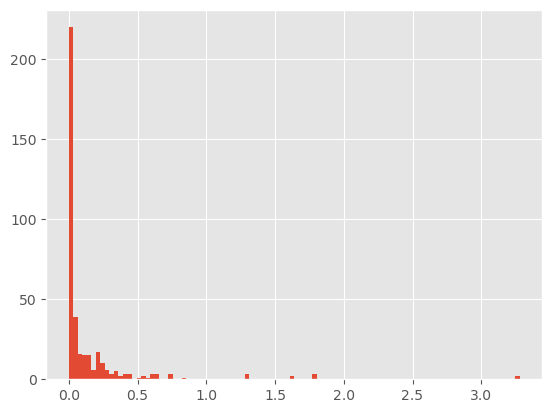

In [25]:
error_abs = (abs(pipe_xgbr.predict(X_test) - y_test)) / y_test
print(error_abs.mean(), error_abs.median())
error_abs.hist(bins=100)

In [26]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).describe()

,0
count,384.000
mean,133751.875
std,60385.809
min,17030.752
25%,79120.711
50%,146721.477
75%,173927.699
max,294648.156


array([[<Axes: title={'center': '0'}>]], dtype=object)

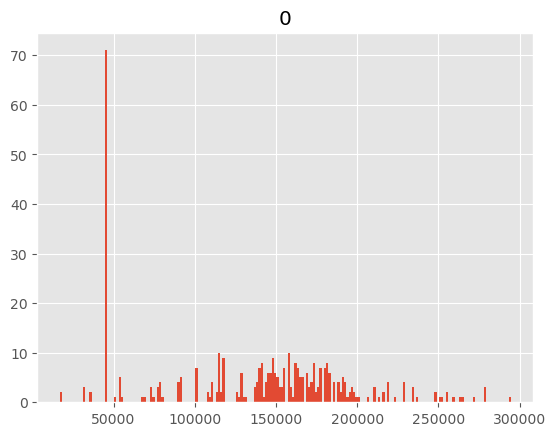

In [27]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).hist(bins=200)

/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


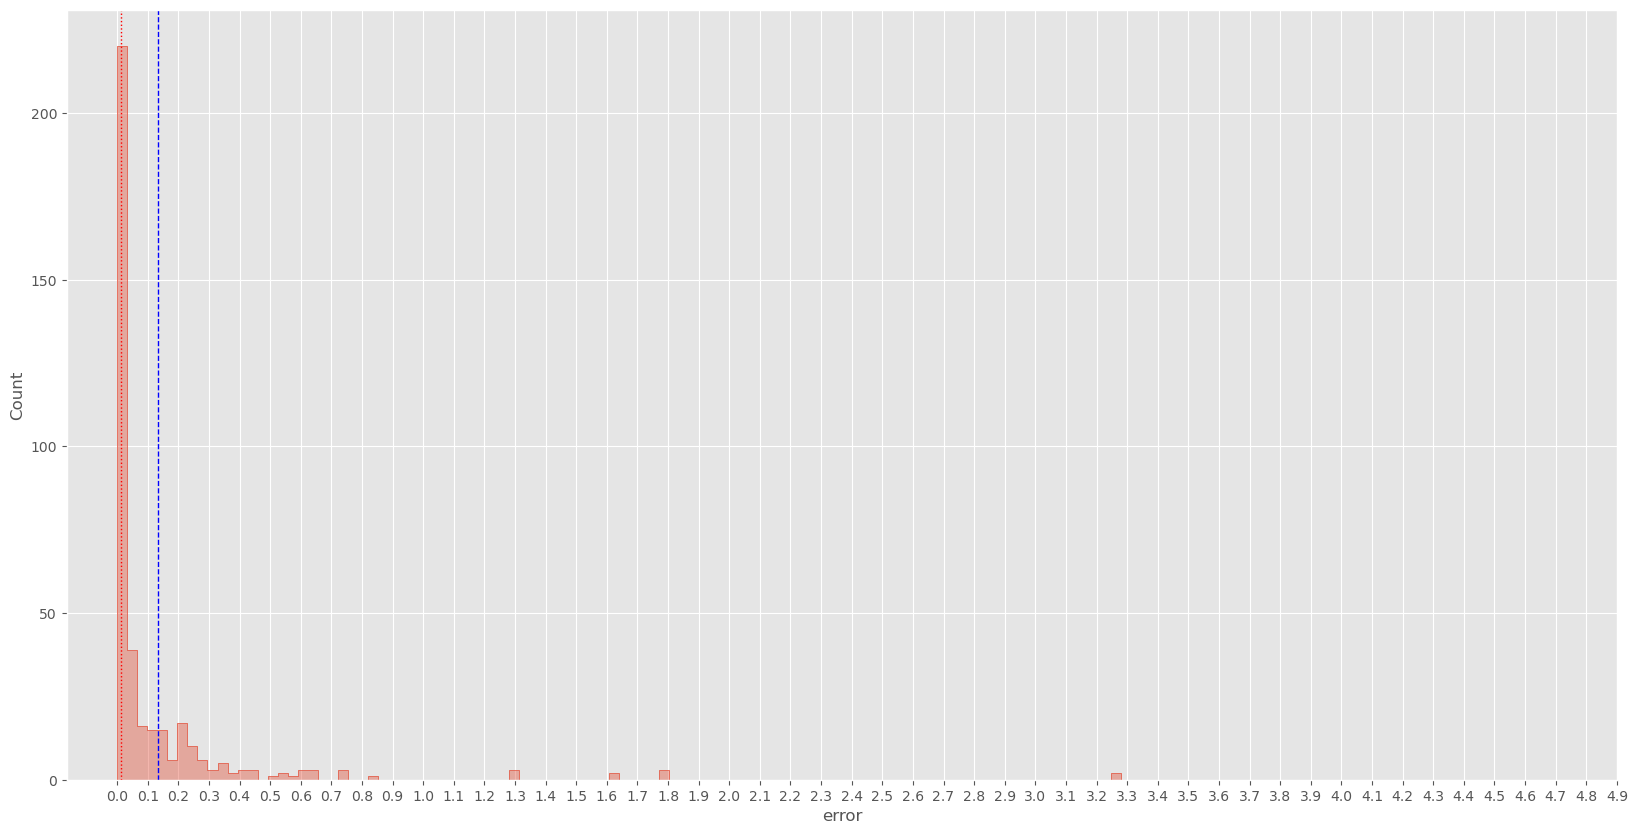

In [28]:
abs_error = abs(y_test - pipe_xgbr.predict(X_test)) / y_test


# sns mean + median  mlflow fig 

plt.figure(figsize=(20, 10))
sns.histplot(abs_error, alpha=0.4,  element="step")
plt.xticks(np.arange(0, 5, 0.1))
plt.axvline(x=abs_error.mean(), color='b', ls='--', lw=1, label='Mean value of abs error')
plt.axvline(x=abs_error.median(), color='r', ls=':', lw=1, label='Median value of abs error')
plt.xlabel('error')
plt.show()

<Axes: >

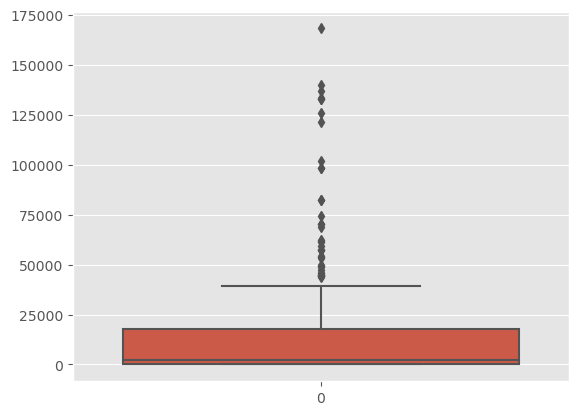

In [29]:
sns.boxplot(pd.Series(abs(y_test - pipe_xgbr.predict(X_test))))

In [30]:
pipe_xgbr.predict(X_test)

array([177345.38 , 172601.36 ,  35097.586, 148713.48 , 130451.21 ,
       188291.2  , 137078.11 , 114962.93 , 229031.9  ,  90563.055,
       139137.81 , 229031.9  ,  45782.68 , 182277.25 , 115028.984,
       192678.88 , 176334.38 , 177345.38 , 149863.5  , 181360.6  ,
        45782.68 , 183147.78 ,  45782.68 ,  45782.68 , 144454.48 ,
       262804.06 , 190919.89 , 278940.6  ,  45782.68 , 150752.86 ,
       163515.56 ,  79120.71 ,  45782.68 , 146894.44 ,  45782.68 ,
       183147.78 ,  45782.68 , 150806.77 ,  45782.68 , 229031.9  ,
       117578.46 , 190919.89 ,  45782.68 , 150713.72 , 117356.97 ,
       114167.39 , 195144.62 , 117356.97 ,  45782.68 ,  45782.68 ,
       234104.06 , 150700.64 ,  45782.68 , 251995.1  ,  45782.68 ,
       175432.48 , 113505.8  , 115028.984, 234104.06 , 131354.45 ,
        45782.68 , 213256.88 ,  45782.68 , 255567.89 ,  45782.68 ,
        17030.752, 197975.3  , 233784.06 , 174690.44 , 139330.77 ,
        45782.68 , 255282.75 , 190279.9  , 218959.66 , 127563.

## Importances

In [31]:
pipe_xgbr['model_xgbr'].feature_importances_

array([0.10933174, 0.04853418, 0.06340028, 0.41332415, 0.16807242,
       0.06275285, 0.11122936, 0.02335503], dtype=float32)

In [32]:
pipe_xgbr['preprocessor'].get_feature_names_out()

array(['num_transformer__distance', 'num_transformer__days',
       'cat_transformer__own_container_1',
       'cat_transformer__complect_send_1',
       'cat_transformer__container_train_1',
       'cat_transformer__transportation_type_2',
       'cat_transformer__transportation_type_3',
       'cat_transformer__transportation_type_4'], dtype=object)

/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pmu/miniconda3/envs/zhd_transport_price/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='importance', ylabel='name'>

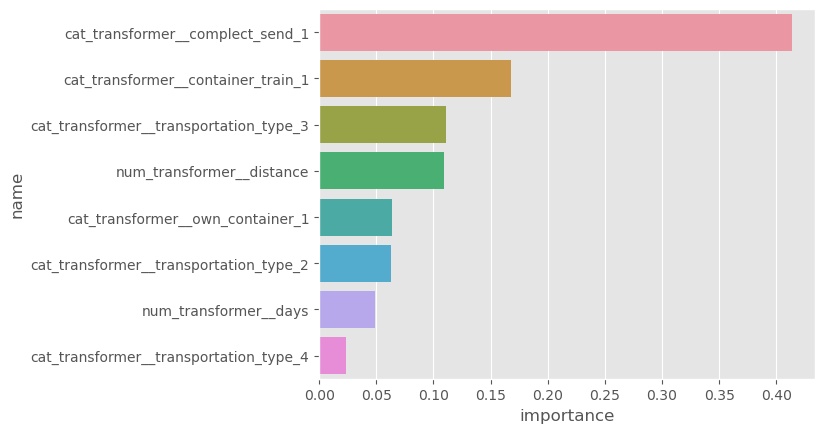

In [33]:
# Importing the required data into a Pandas DataFrame
importance = pd.DataFrame({
    'name': pipe_xgbr['preprocessor'].get_feature_names_out(), # Get names of the features used in the model
    'importance': pipe_xgbr['model_xgbr'].feature_importances_ # Get the importance of each feature
})

# Sorting the data based on the importance of each feature
importance.sort_values('importance', ascending=False, inplace=True)

# Plotting a barplot of the feature importances using seaborn
sns.barplot(data=importance, y='name', x='importance')

## Save model

In [34]:

logged_model_2 = 'runs:/90c5704b61d54aee903cde0fcde573c4/best_model'

# Load model as a PyFuncModel.
loaded_model_2 = mlflow.pyfunc.load_model(logged_model_2)

loaded_model_2.predict(X_test)

array([177345.38 , 172601.36 ,  35097.586, 148713.48 , 130451.21 ,
       188291.2  , 137078.11 , 114962.93 , 229031.9  ,  90563.055,
       139137.81 , 229031.9  ,  45782.68 , 182277.25 , 115028.984,
       192678.88 , 176334.38 , 177345.38 , 149863.5  , 181360.6  ,
        45782.68 , 183147.78 ,  45782.68 ,  45782.68 , 144454.48 ,
       262804.06 , 190919.89 , 278940.6  ,  45782.68 , 150752.86 ,
       163515.56 ,  79120.71 ,  45782.68 , 146894.44 ,  45782.68 ,
       183147.78 ,  45782.68 , 150806.77 ,  45782.68 , 229031.9  ,
       117578.46 , 190919.89 ,  45782.68 , 150713.72 , 117356.97 ,
       114167.39 , 195144.62 , 117356.97 ,  45782.68 ,  45782.68 ,
       234104.06 , 150700.64 ,  45782.68 , 251995.1  ,  45782.68 ,
       175432.48 , 113505.8  , 115028.984, 234104.06 , 131354.45 ,
        45782.68 , 213256.88 ,  45782.68 , 255567.89 ,  45782.68 ,
        17030.752, 197975.3  , 233784.06 , 174690.44 , 139330.77 ,
        45782.68 , 255282.75 , 190279.9  , 218959.66 , 127563.

In [35]:
abs(y_test - loaded_model_2.predict(X_test)).median()


2020.5654296875

In [36]:
# joblib.dump(loaded_model_2, "best_model.joblib")

['best_model.joblib']

In [49]:
best_model = joblib.load('model_test.joblib')

## API 

In [31]:
results = requests.get('http://127.0.0.1:8000/test')
results

<Response [200]>

In [101]:
output_list = requests.post('http://localhost:8000/xout_list', json=X_test.to_dict(orient='list')) # 2 format # predict  # check mse + all + class
output_list

<Response [200]>

In [99]:
output_dict = requests.post('http://localhost:8000/xout_dict', json=X_test.to_dict(orient='dict'))
output_dict

<Response [200]>

In [50]:

predict_test = requests.post('http://localhost:8000/predict', json=X_test.to_dict(orient='list'))
y_pred = pd.Series(json.loads(predict_test.text))

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae

13874.190785725912

In [94]:
np.array(predict_test)

array(<Response [200]>, dtype=object)

In [44]:
model = joblib.load('model_test.joblib')
model.predict(X_test)

array([179031.58 , 169882.81 ,  34546.555, 149143.84 , 129089.52 ,
       188839.25 , 137133.22 , 115105.266, 228823.34 ,  90926.86 ,
       139675.31 , 228823.34 ,  46101.71 , 182549.77 , 118209.73 ,
       193120.52 , 175533.39 , 179031.58 , 147918.95 , 179934.22 ,
        46101.71 , 182840.88 ,  46101.71 ,  46101.71 , 146789.19 ,
       262966.   , 194121.47 , 278859.9  ,  46101.71 , 150995.25 ,
       163135.03 ,  79838.42 ,  46101.71 , 148925.27 ,  46101.71 ,
       182840.88 ,  46101.71 , 151043.19 ,  46101.71 , 228823.34 ,
       117699.305, 194121.47 ,  46101.71 , 150042.38 , 119679.445,
       114790.28 , 196185.47 , 119679.445,  46101.71 ,  46101.71 ,
       237012.66 , 150074.98 ,  46101.71 , 251653.3  ,  46101.71 ,
       170753.36 , 117953.52 , 118209.73 , 237012.66 , 122870.46 ,
        46101.71 , 211291.8  ,  46101.71 , 254643.97 ,  46101.71 ,
        16796.334, 192953.58 , 230929.42 , 178800.56 , 139861.03 ,
        46101.71 , 256232.38 , 185407.77 , 220038.77 , 132790.

In [ ]:
text = 'text name'

print_text = requests.post('http://127.0.0.1:8000/text', json={'test': text})
print_text.json()

{'text': {'test': 'text name'}}